In [42]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import mean_squared_error,mean_absolute_error

# Modeling and Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster,bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.model_selection import select_features
import shap

from xgboost import XGBRegressor, plot_importance

In [2]:
def train_val_test_split(serie,tr_size=0.90,ts_size=0.1):

     N = serie.shape[0]

     Ntrain = int(tr_size*N) # Número de datos de entrenamiento

     Ntest = int(ts_size *N) # Número de datos de validación


     # Partición

     train = serie[0:Ntrain]
     test = serie[Ntrain:]

     return train,test

In [3]:
def add_lags(df):

    df['lag1']= (df.index - pd.Timedelta('30 days')).map(target_map)

    df['lag2']= (df.index - pd.Timedelta('60 days')).map(target_map)

    df['lag3']= (df.index - pd.Timedelta('364 days')).map(target_map)

    return df

In [4]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [5]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

In [6]:
df = pd.read_csv('BD preprocesada II.csv',sep=',')

# Formatear columna Fecha como datetime

df['Fecha'] = pd.to_datetime(df['Fecha'])

# df = df[['Fecha','AUM FIC']]

df = df.rename(columns={'Fecha':'ds','AUM FIC':'y'})

df.drop_duplicates(keep='first',inplace=True,ignore_index=False)

# Fecha como índice

df.set_index('ds',inplace=True)

df.tail()

,y,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa A 120 días,Tasa Entre 121 y 179 días,Tasa A 180 días,Tasa Entre 181 y 359 días,Tasa A 360 días,Tasa Superiores a 360 días,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR
ds,,,,,,,,,,,,,,,,,,,,,
2024-08-03,8.276074e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-04,8.277857e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-05,8.297109e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-06,8.339252e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05
2024-08-07,8.335225e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.80099,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.10044,0.107696,343.99,4022.05


In [7]:
df.columns

Index(['y', 'Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR'],
      dtype='object')

In [8]:
# df_model = df[['y','CDT 1/']]

df_model = df.copy()

df_model

,y,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa A 120 días,Tasa Entre 121 y 179 días,Tasa A 180 días,Tasa Entre 181 y 359 días,Tasa A 360 días,Tasa Superiores a 360 días,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.277819e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.68,4.75,...,0.052668,0.055417,0.052354,0.058845,0.057049,0.061108,0.052959,0.058457,286.55,2940.94
2018-01-02,4.346588e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052668,0.055417,0.052354,0.058845,0.057049,0.061108,0.052959,0.058457,286.55,2940.94
2018-01-03,4.427526e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.053122,0.056538,0.054354,0.059277,0.055647,0.065069,0.052840,0.064005,286.55,2940.94
2018-01-04,4.457223e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.050867,0.054752,0.053794,0.058336,0.056066,0.066029,0.052695,0.064102,286.55,2908.68
2018-01-05,4.464074e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.051841,0.055389,0.054582,0.056345,0.055165,0.062512,0.052718,0.057780,286.55,2885.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03,8.276074e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.100440,0.107696,343.99,4022.05
2024-08-04,8.277857e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.100440,0.107696,343.99,4022.05
2024-08-05,8.297109e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100588,0.102314,0.102521,0.106169,0.107774,0.106101,0.100440,0.107696,343.99,4022.05


In [9]:
df_model = create_attributes(df_model)
df_model

,y,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR,day,dayofweek,month,quarter,year,dayofyear
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.277819e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.68,4.75,...,0.052959,0.058457,286.55,2940.94,1,0,1,1,2018,1
2018-01-02,4.346588e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052959,0.058457,286.55,2940.94,2,1,1,1,2018,2
2018-01-03,4.427526e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052840,0.064005,286.55,2940.94,3,2,1,1,2018,3
2018-01-04,4.457223e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052695,0.064102,286.55,2908.68,4,3,1,1,2018,4
2018-01-05,4.464074e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052718,0.057780,286.55,2885.76,5,4,1,1,2018,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03,8.276074e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,3,5,8,3,2024,216
2024-08-04,8.277857e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,4,6,8,3,2024,217
2024-08-05,8.297109e+07,113349.537115,41284.585441,55740.710863,12412.767407,298898.800990,308954.440917,11117.476384,7.16,11.25,...,0.100440,0.107696,343.99,4022.05,5,0,8,3,2024,218


In [10]:
# Verify that a temporary index is complete
# ==============================================================================
start_date = df_model.index.min()
end_date = df_model.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=df_model.index.freq)
is_index_complete = (df_model.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")

Index complete: True


In [11]:
df_model = df_model.asfreq('D')

In [12]:
tr,ts = train_val_test_split(df_model)

print(f'Tamaño set de entrenamiento: {tr.shape}')

print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2169, 34)
Tamaño set de prueba: (242, 34)


## Forecaster con solo la variable objetivo

In [14]:
# Create and train forecaster
# ==============================================================================
forecaster_1 = ForecasterAutoreg(
                 regressor = XGBRegressor(n_estimators = 100,max_depth=3,learning_rate= 0.1,random_state=123),
                 lags      = 150
             )
forecaster_1.fit(y=tr['y'])
forecaster_1

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  5

In [15]:
# Predictions
# ==============================================================================
steps = 242
predictions_1 = forecaster_1.predict(steps=steps)
predictions_1.head(5)

2023-12-10    71350560.0
2023-12-11    71347056.0
2023-12-12    71367480.0
2023-12-13    71367480.0
2023-12-14    71367480.0
Freq: D, Name: pred, dtype: float64

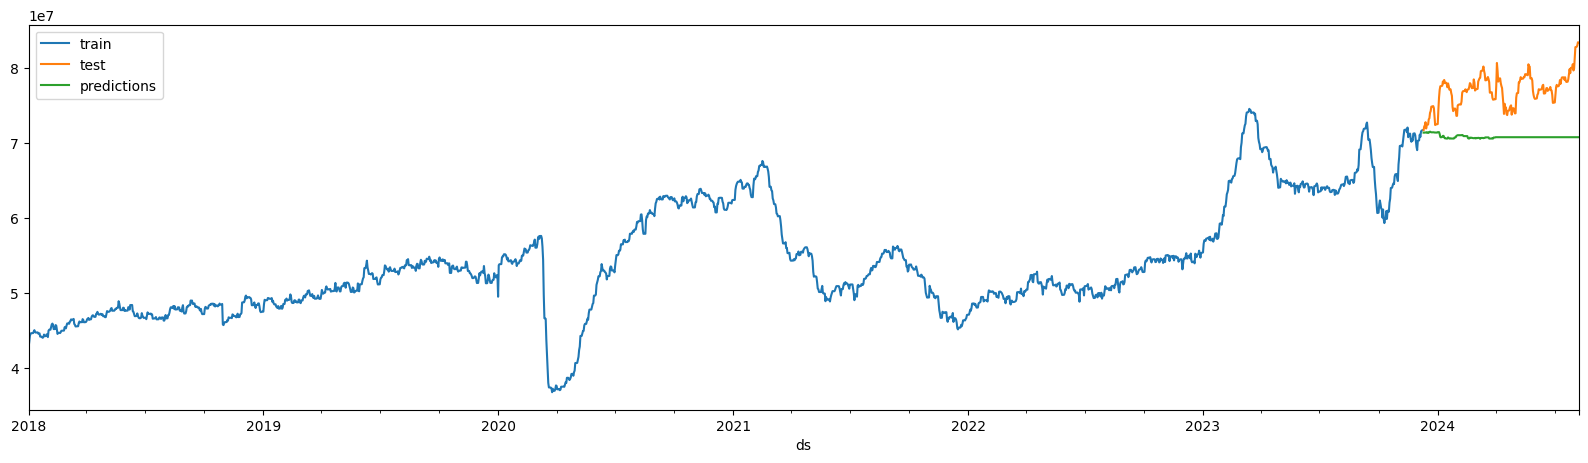

In [16]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
ts['y'].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions')
ax.legend();

In [17]:
metricas_XGBoost= calculate_metrics(ts['y'],predictions_1)

### Backtesting

In [18]:
metric_1, predictions_1_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_1,
                          y                  = df_model['y'],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(tr),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_1)

predictions_1_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<00:00, 1168.08it/s]


1717565.9432962532

,pred
2023-12-10,71350560.0
2023-12-11,71347056.0
2023-12-12,71367480.0
2023-12-13,71367480.0
2023-12-14,71367480.0


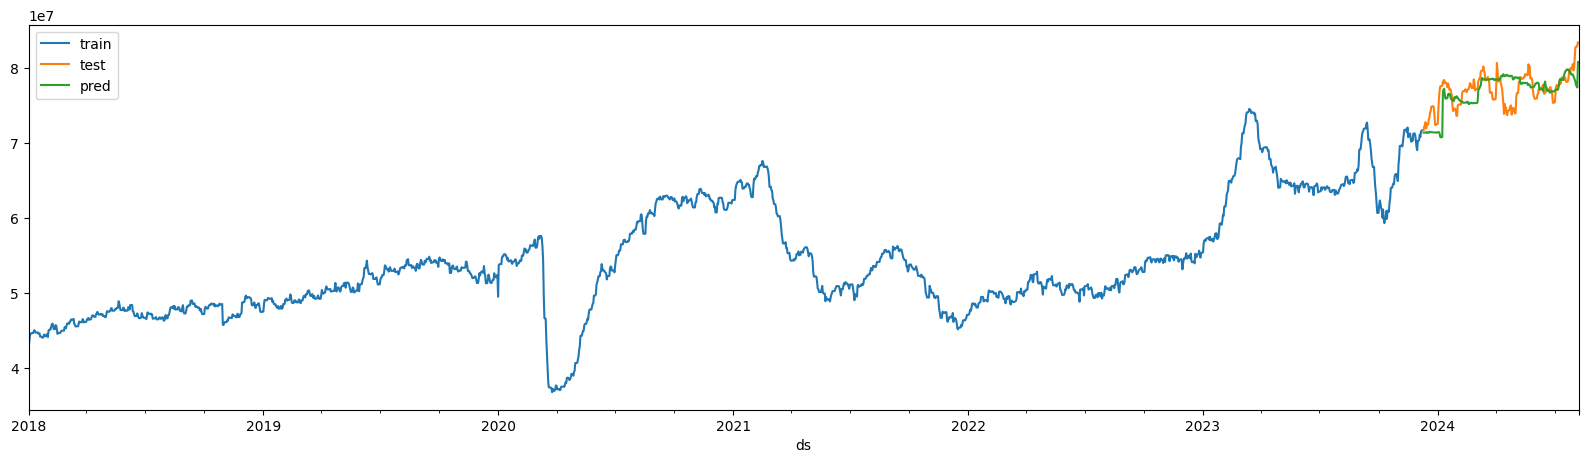

In [19]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
ts['y'].plot(ax=ax, label='test')
predictions_1_backtesting.plot(ax=ax, label='predictions')
ax.legend();

In [20]:
metricas_XGBoost_2= calculate_metrics(ts['y'],predictions_1_backtesting)

## Variables Exógenas

In [21]:
# Create and train forecaster
# ==============================================================================
forecaster_2 = ForecasterAutoreg(
                 regressor = XGBRegressor(n_estimators = 100,max_depth=3,learning_rate= 0.1,random_state=123),
                 lags      = 150
             )
forecaster_2.fit(y=tr['y'],exog=tr[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']])
forecaster_2


ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  5

In [22]:
# Predictions
# ==============================================================================
steps = 242
predictions_2 = forecaster_2.predict(steps=steps,exog=ts[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']])
predictions_2.head(5)

2023-12-10    71600112.0
2023-12-11    71594696.0
2023-12-12    71336024.0
2023-12-13    71560536.0
2023-12-14    71443968.0
Freq: D, Name: pred, dtype: float64

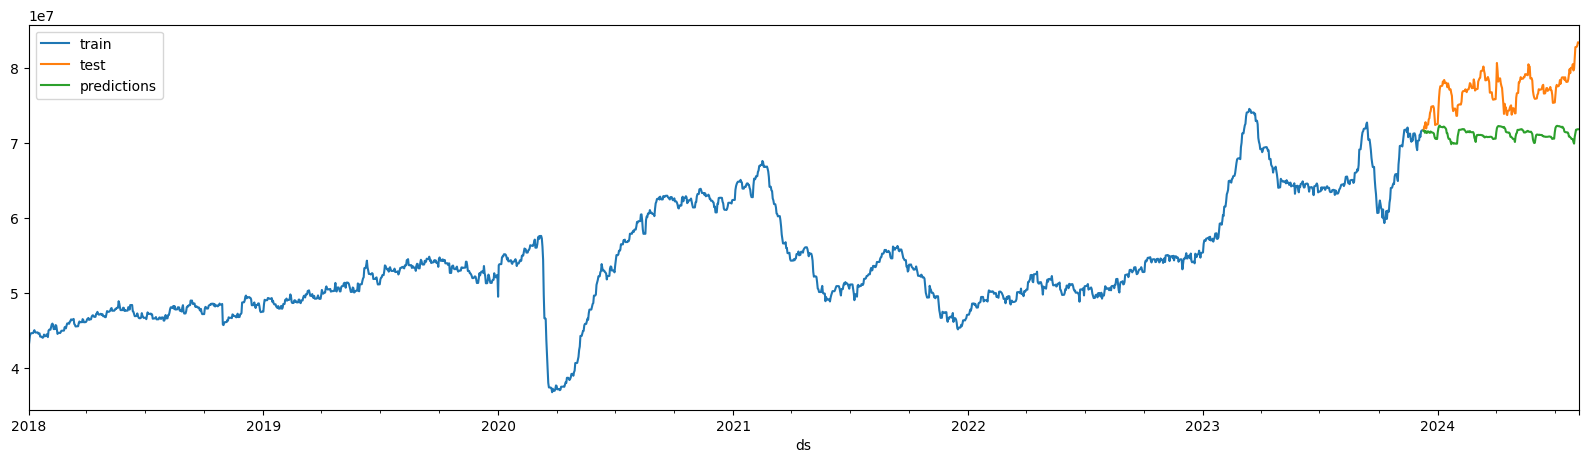

In [23]:
# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 5))
tr['y'].plot(ax=ax, label='train')
ts['y'].plot(ax=ax, label='test')
predictions_2.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
metricas_XGBoost_3= calculate_metrics(ts['y'],predictions_2)

## Backtesting

In [25]:
metric_2, predictions_2_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_2,
                          y                  = df_model['y'],
                          exog= df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(tr),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_2)

predictions_2_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<00:00, 8998.51it/s]


1818209.8355071878

,pred
2023-12-10,71600112.0
2023-12-11,71594696.0
2023-12-12,71336024.0
2023-12-13,71560536.0
2023-12-14,71443968.0


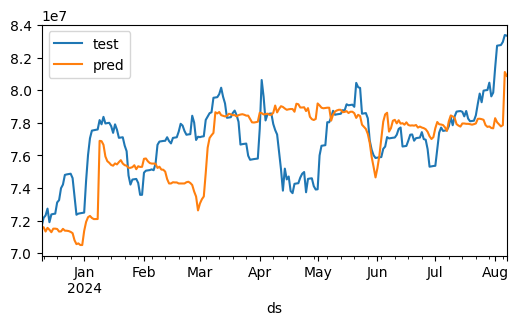

In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
ts['y'].plot(ax=ax, label='test')
predictions_2_backtesting.plot(ax=ax)
ax.legend()
plt.show();

In [84]:
metricas_XGBoost_4=calculate_metrics(ts['y'],predictions_2_backtesting)

## Búsqueda Hiperparámetros

In [36]:
# Hyperparameters search
# ==============================================================================

exog = df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']]


# Lags grid
lags_grid = [120,150,180]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster_2,
    y                  = df_model['y'],
    exog               = exog,
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(tr),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

Best trial: 11. Best value: 4.34504e+06: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120] 
  Parameters: {'n_estimators': 1200, 'max_depth': 3, 'learning_rate': 0.43135295724087064, 'subsample': 0.7305254129173101, 'colsample_bytree': 0.6040997247466926, 'gamma': 0.4347093524818002, 'reg_alpha': 0.9731210959629483, 'reg_lambda': 0.3311404017818648}
  Backtesting metric: 4345044.325554915



In [37]:
metric_3, predictions_3_backtesting = backtesting_forecaster(
                          forecaster         = forecaster_2,
                          y                  = df_model['y'],
                          exog= df_model[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']],
                          steps              = 30,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(tr),
                          refit              = True,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

display(metric_3)

predictions_3_backtesting.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2169
Number of observations used for backtesting: 242
    Number of folds: 9
    Number of steps per fold: 30
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-09 00:00:00  (n=2169)
    Validation: 2023-12-10 00:00:00 -- 2024-01-08 00:00:00  (n=30)
Fold: 1
    Training:   2018-01-31 00:00:00 -- 2024-01-08 00:00:00  (n=2169)
    Validation: 2024-01-09 00:00:00 -- 2024-02-07 00:00:00  (n=30)
Fold: 2
    Training:   2018-03-02 00:00:00 -- 2024-02-07 00:00:00  (n=2169)
    Validation: 2024-02-08 00:00:00 -- 2024-03-08 00:00:00  (n=30)
Fold: 3
    Training:   2018-04-01 00:00:00 -- 2024-03-08 00:00:00  (n=2169)
    Validation: 2024-03-09 00:00:00 -- 2024-04-07 00:00:00  (n=30)
Fold: 4
    Training:   2018-05-01 00:00:00 -- 2024-04-07 00:00:00

100%|██████████| 9/9 [00:00<?, ?it/s]


2280186.1160530294

,pred
2023-12-10,71650424.0
2023-12-11,71586848.0
2023-12-12,71754760.0
2023-12-13,71267312.0
2023-12-14,71441792.0


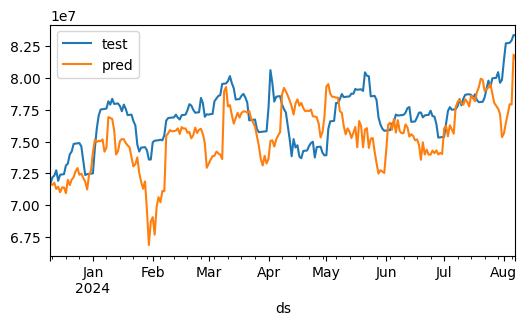

In [38]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
ts['y'].plot(ax=ax, label='test')
predictions_3_backtesting.plot(ax=ax)
ax.legend()
plt.show();

In [39]:
metricas_XGBoost_5=calculate_metrics(ts['y'],predictions_3_backtesting)

In [40]:
# Comparar resultados
resultados = pd.DataFrame({
    'Model': ['XGBoost solo variable objetivo','XGBoost solo variable objetivo Backtesting','XGBoost Variables Exógenas','XGBoost Variables Exógenas Backtesting','XGBoost Variables Exógenas Selección Parámetros'],
    'MSE': [metricas_XGBoost[0],metricas_XGBoost_2[0],metricas_XGBoost_3[0],metricas_XGBoost_4[0],metricas_XGBoost_5[0]],
    'RMSE': [metricas_XGBoost[1],metricas_XGBoost_2[1],metricas_XGBoost_3[1],metricas_XGBoost_4[1],metricas_XGBoost_5[1]],
    'MAE': [metricas_XGBoost[2],metricas_XGBoost_2[2],metricas_XGBoost_3[2],metricas_XGBoost_4[2],metricas_XGBoost_5[2]],
    'MAPE': [metricas_XGBoost[3],metricas_XGBoost_2[3],metricas_XGBoost_3[3],metricas_XGBoost_4[3],metricas_XGBoost_5[3]]
})

resultados

,Model,MSE,RMSE,MAE,MAPE
0,XGBoost solo variable objetivo,4.342613e+13,6.589851e+06,6.163460e+06,7.928048
1,XGBoost solo variable objetivo Backtesting,5.110340e+12,2.260606e+06,1.717566e+06,NaN
2,XGBoost Variables Exógenas,3.769615e+13,6.139719e+06,5.747996e+06,7.397346
3,XGBoost Variables Exógenas Backtesting,5.403306e+12,2.324501e+06,1.818210e+06,NaN
4,XGBoost Variables Exógenas Selección Parámetros,7.438306e+12,2.727326e+06,2.280186e+06,NaN


## Selección de características

In [158]:
# # Hyperparameters: grid search
# # ==============================================================================
# steps = 242

# exog = tr[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
#        'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
#        'Otros depósitos a la vista', 'Inflación anual %',
#        'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
#        'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
#        'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
#        'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
#        'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
#        'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
#        'Tasa Superiores a 360 días',
#        'Tasa Captaciones a través de CDT por red de oficinas',
#        'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
#        'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']]

# forecaster = ForecasterAutoreg(
#                  regressor = XGBRegressor(random_state=123),
#                  lags      = 180 # This value will be replaced in the grid search
#              )

# # Candidate values for lags
# lags_grid = [120,150,180]

# # Candidate values for learning rate
# learning_rate_grid = [0.1,0.01,0.001]

# # Candidate values for regressor's hyperparameters
# param_grid = {
#     'n_estimators': [1000,2000,5000],
#     'max_depth': [3, 8,10,20],
#     'learning_rate': [0.1,0.01,0.001]
# }

# results_grid = grid_search_forecaster(
#                    forecaster         = forecaster,
#                    y                  = tr['y'],
#                    param_grid         = param_grid,
#                    exog               = exog,
#                    lags_grid          = lags_grid,
#                    steps              = steps,
#                    metric             = 'mean_squared_error',
#                    initial_train_size = int(len(tr)*0.5),
#                    fixed_train_size   = False,
#                    refit              = False,
#                    return_best        = True,
#                    n_jobs             = 'auto',
#                    verbose            = False
#                )

Number of models compared: 108.


lags grid: 100%|██████████| 3/3 [1:28:59<00:00, 1779.75s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 2000}
  Backtesting metric: 52404442808224.266



In [115]:
# Create forecaster
# ==============================================================================
regressor = XGBRegressor(
    n_estimators = 1200, max_depth = 3, learning_rate = 0.43135295724087064, subsample = 0.7305254129173101, colsample_bytree = 0.6040997247466926, gamma = 0.4347093524818002, reg_alpha = 0.9731210959629483, reg_lambda = 0.3311404017818648,random_state=15926
)
forecaster_1 = ForecasterAutoreg(
    regressor = regressor,
    lags      = 150,
)


# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 10,
    n_jobs                 = -1,
    scoring='neg_mean_absolute_error'
)


In [116]:
# selected_lags, selected_exog = select_features(
#     forecaster      = forecaster_1,
#     selector        = selector,
#     y               = tr['y'],  
#     exog            = tr[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
#        'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
#        'Otros depósitos a la vista', 'Inflación anual %',
#        'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
#        'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
#        'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
#        'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
#        'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
#        'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
#        'Tasa Superiores a 360 días',
#        'Tasa Captaciones a través de CDT por red de oficinas',
#        'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
#        'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']],
#     select_only     = None,
#     force_inclusion = None,
#     subsample       = 0.5,
#     random_state    = 123,
#     verbose         = True,
# )

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 2019
Total number of records used for feature selection: 1009
Number of features available: 183
    Autoreg (n=150)
    Exog    (n=33)
Number of features selected: 53
    Autoreg (n=33) : [1, 2, 3, 5, 7, 15, 21, 24, 28, 30, 34, 35, 37, 41, 44, 45, 50, 55, 58, 65, 78, 84, 93, 102, 105, 119, 129, 130, 133, 135, 140, 146, 149]
    Exog    (n=20) : ['Efectivo', 'Reserva Bancaria', 'Del sector privado', 'Del sector público', 'Tasa 30 días', 'Tasa Entre 31 y 44 días', 'Tasa Entre 46 y 59 días', 'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días', 'Tasa Entre 91 y 119 días', 'Tasa A 120 días', 'Tasa Entre 121 y 179 días', 'Tasa A 180 días', 'Tasa Entre 181 y 359 días', 'Tasa A 360 días', 'Tasa Superiores a 360 días', 'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'day']


In [117]:
selected_exog

['Efectivo',
 'Reserva Bancaria',
 'Del sector privado',
 'Del sector público',
 'Tasa 30 días',
 'Tasa Entre 31 y 44 días',
 'Tasa Entre 46 y 59 días',
 'Tasa A 60 días',
 'Tasa Entre 61 y 89 días',
 'Tasa A 90 días',
 'Tasa Entre 91 y 119 días',
 'Tasa A 120 días',
 'Tasa Entre 121 y 179 días',
 'Tasa A 180 días',
 'Tasa Entre 181 y 359 días',
 'Tasa A 360 días',
 'Tasa Superiores a 360 días',
 'Tasa Captaciones a través de CDT por tesorería',
 'Valor hoy',
 'day']

In [107]:
selected_lags

[1, 2, 44, 119]

In [162]:
# Create a forecaster with the selected features
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators = 1200, max_depth = 3, learning_rate = 0.43135295724087064, subsample = 0.7305254129173101, colsample_bytree = 0.6040997247466926, gamma = 0.4347093524818002, reg_alpha = 0.9731210959629483, reg_lambda = 0.3311404017818648,random_state=15926, enable_categorical=True),
    lags      = 150
)

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_4, predictions_4 = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = df_model['y'],
    exog               = df_model[['day','CDT 1/']],
    steps              = 30,
    metric             = 'mean_absolute_error',
    initial_train_size = len(tr),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metric_4

100%|██████████| 9/9 [00:00<00:00, 100.03it/s]


5498433.879417043

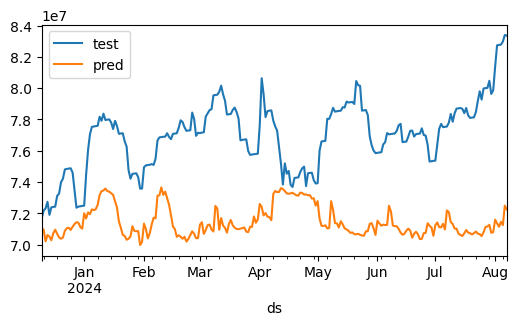

In [159]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
ts['y'].plot(ax=ax, label='test')
predictions_4.plot(ax=ax)
ax.legend()
plt.show();

In [156]:
metricas_XGBoost_6=calculate_metrics(ts['y'],predictions_4)

In [160]:
# Comparar resultados
resultados = pd.DataFrame({
    'Model': ['XGBoost solo variable objetivo','XGBoost solo variable objetivo Backtesting','XGBoost Variables Exógenas','XGBoost Variables Exógenas Backtesting','XGBoost Variables Exógenas Selección Parámetros','XGBoost best features'],
    'MSE': [metricas_XGBoost[0],metricas_XGBoost_2[0],metricas_XGBoost_3[0],metricas_XGBoost_4[0],metricas_XGBoost_5[0],metricas_XGBoost_6[0]],
    'RMSE': [metricas_XGBoost[1],metricas_XGBoost_2[1],metricas_XGBoost_3[1],metricas_XGBoost_4[1],metricas_XGBoost_5[1],metricas_XGBoost_6[1]],
    'MAE': [metricas_XGBoost[2],metricas_XGBoost_2[2],metricas_XGBoost_3[2],metricas_XGBoost_4[2],metricas_XGBoost_5[2],metricas_XGBoost_6[2]],
    'MAPE': [metricas_XGBoost[3],metricas_XGBoost_2[3],metricas_XGBoost_3[3],metricas_XGBoost_4[3],metricas_XGBoost_5[3],metricas_XGBoost_5[3]]
})

resultados

,Model,MSE,RMSE,MAE,MAPE
0,XGBoost solo variable objetivo,4.342613e+13,6.589851e+06,6.163460e+06,7.928048
1,XGBoost solo variable objetivo Backtesting,5.110340e+12,2.260606e+06,1.717566e+06,NaN
2,XGBoost Variables Exógenas,3.769615e+13,6.139719e+06,5.747996e+06,7.397346
3,XGBoost Variables Exógenas Backtesting,5.403306e+12,2.324501e+06,1.818210e+06,NaN
4,XGBoost Variables Exógenas Selección Parámetros,7.438306e+12,2.727326e+06,2.280186e+06,NaN
5,XGBoost best features,6.455329e+13,8.034506e+06,7.624719e+06,NaN


## Importancia de las características

In [148]:
# Create a forecaster with the selected features
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(n_estimators = 1200, max_depth = 3, learning_rate = 0.43135295724087064, subsample = 0.7305254129173101, colsample_bytree = 0.6040997247466926, gamma = 0.4347093524818002, reg_alpha = 0.9731210959629483, reg_lambda = 0.3311404017818648,random_state=15926, enable_categorical=True),
    lags      = 150
)

forecaster.fit(
    y    = tr['y'],
    exog = tr[['Efectivo', 'Reserva Bancaria', 'Del sector privado',
       'Del sector público', 'Cuentas de ahorro', 'CDT 1/',
       'Otros depósitos a la vista', 'Inflación anual %',
       'Tasa de intervención de política monetaria (%)', 'Tasa 30 días',
       'Tasa Entre 31 y 44 días', 'Tasa A 45 días', 'Tasa Entre 46 y 59 días',
       'Tasa A 60 días', 'Tasa Entre 61 y 89 días', 'Tasa A 90 días',
       'Tasa Entre 91 y 119 días', 'Tasa A 120 días',
       'Tasa Entre 121 y 179 días', 'Tasa A 180 días',
       'Tasa Entre 181 y 359 días', 'Tasa A 360 días',
       'Tasa Superiores a 360 días',
       'Tasa Captaciones a través de CDT por red de oficinas',
       'Tasa Captaciones a través de CDT por tesorería', 'Valor hoy', 'VALOR',
       'day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']]
)

In [149]:
importance = forecaster.get_feature_importances()
importance.head(20)

,feature,importance
1,lag_2,0.604575
2,lag_3,0.262985
0,lag_1,0.052710
51,lag_52,0.033280
47,lag_48,0.006906
53,lag_54,0.004887
35,lag_36,0.001481
64,lag_65,0.001061
177,day,0.000789
155,CDT 1/,0.000782
